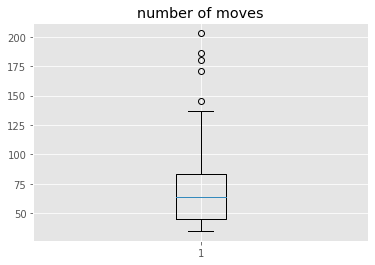

,nbmoves,AZresult,AZwhite
1,35,DRAW,False
25,35,DRAW,False
56,35,DRAW,False
23,35,DRAW,False
35,35,DRAW,False
30,35,DRAW,False
3,36,DRAW,False
77,36,DRAW,False
22,37,DRAW,False
14,38,DRAW,False


In [1]:
%matplotlib inline

import chess.pgn
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pgnfile="TCEC_Season_20_-_Superfinal.pgn" # archive.pgn" 

## basically analysis of PGN 
def nb_moves(g):
    nbmove = 0
    for move in g.mainline_moves():
        if (move is not None):
            nbmove = nbmove + 1
    return nbmove / 2

pgn = open(pgnfile)
df = pd.DataFrame(columns=['nbmoves', "AZresult", "AZwhite"])
idg = 0
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    whiteplayer = game.headers.get("White") == 'AlphaZero'
    result = "WIN" if (whiteplayer and game.headers.get('Result') == '1-0') else ("LOSE" if (whiteplayer and game.headers.get('Result') == '0-1') else "DRAW")
    df.loc[idg] = (int(nb_moves(game)), result, whiteplayer)
    idg = idg + 1
    
df['AZresult'].value_counts()
plt.figure()
plt.boxplot(pd.to_numeric(df['nbmoves']))
plt.title("number of moves")
# df.boxplot(column=['nbmoves'])
plt.show()

#df.boxplot(pd.to_numeric(df['nbmoves']))
#df[df['AZresult'] == 'WIN']
#df
df.sort_values(by="nbmoves")[:20]

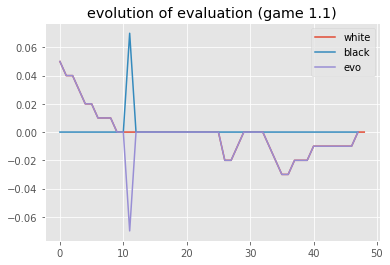

0.07


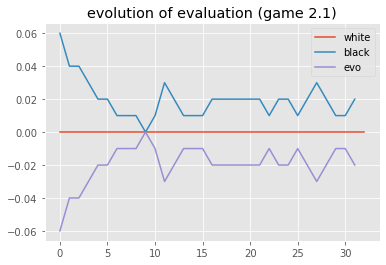

0.06


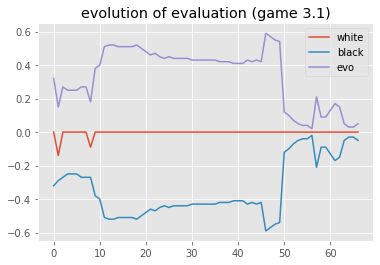

0.59


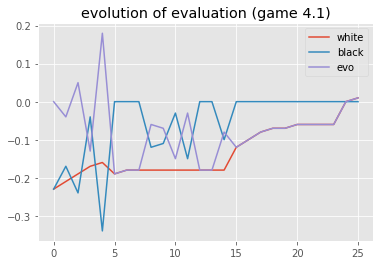

0.19


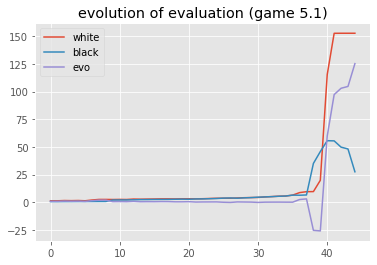

2.960000000000001


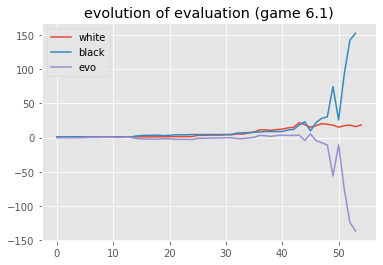

2.8999999999999995


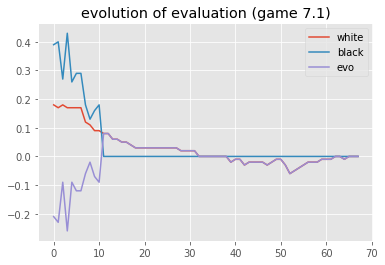

0.26


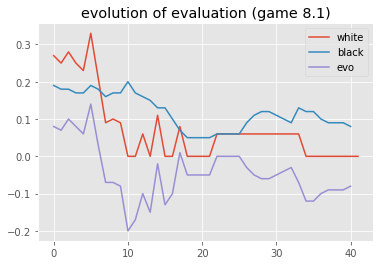

0.2


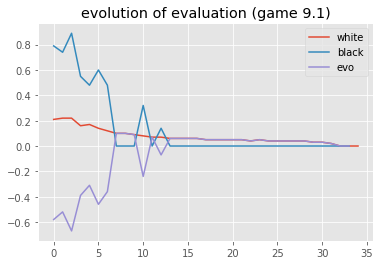

0.67


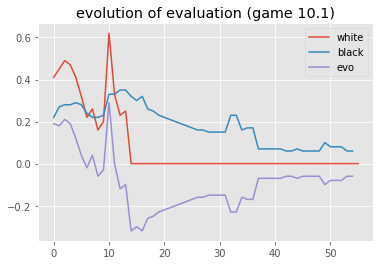

0.32


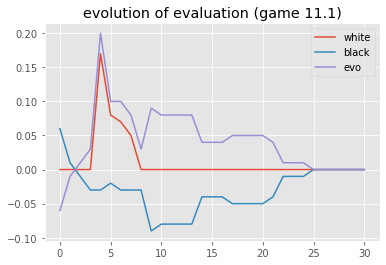

0.2


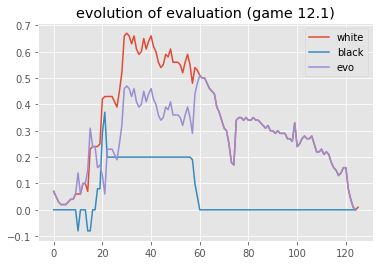

0.51


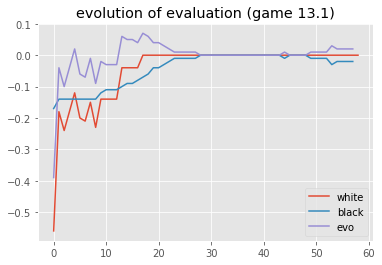

0.39


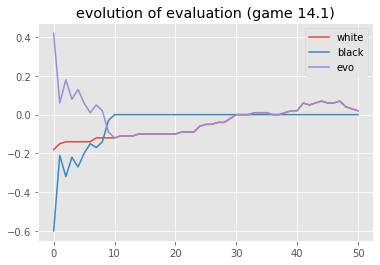

0.42


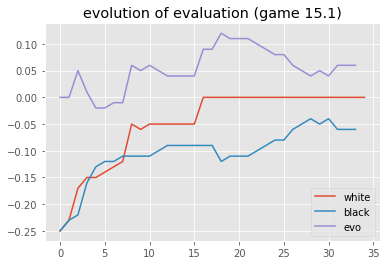

0.12


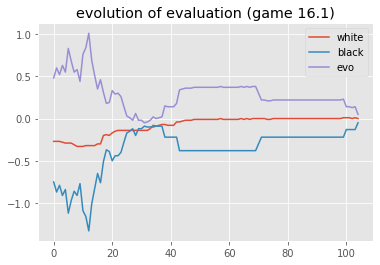

1.01


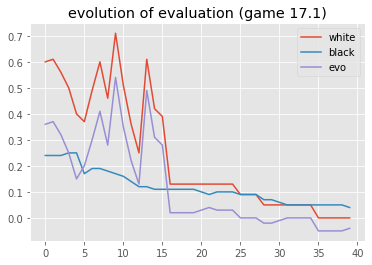

0.5399999999999999


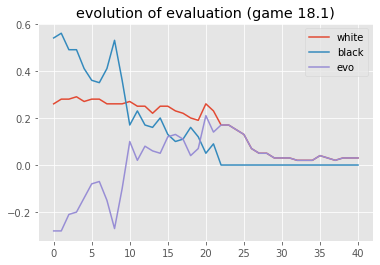

0.28


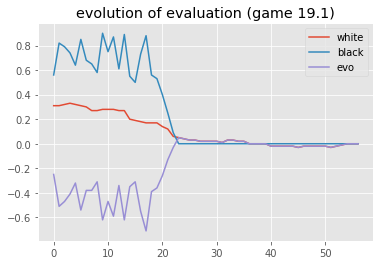

0.71


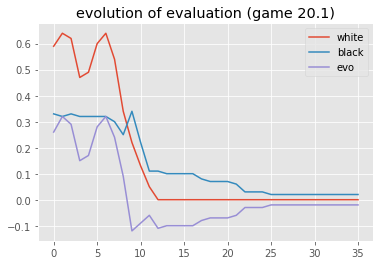

0.32


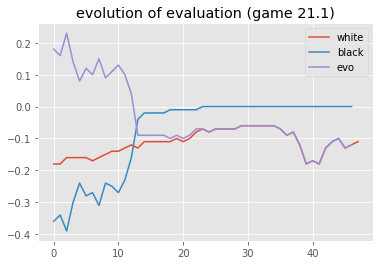

0.23


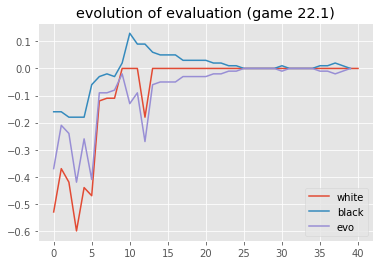

0.42


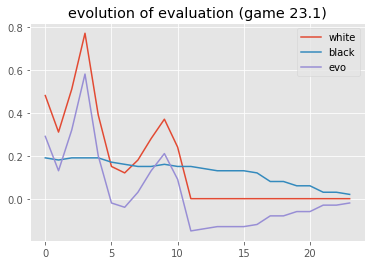

0.5800000000000001


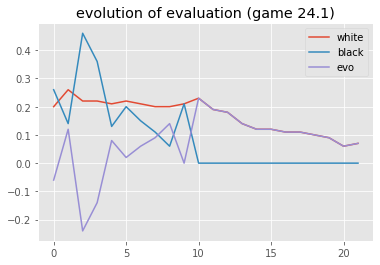

0.24000000000000002


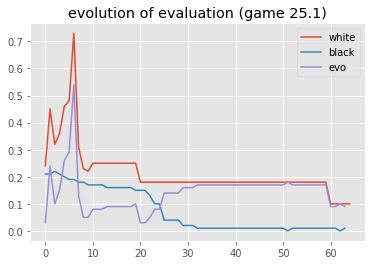

0.54


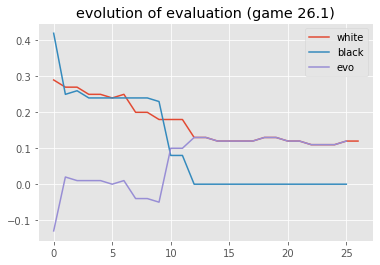

0.13


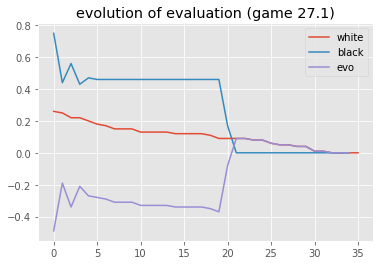

0.49


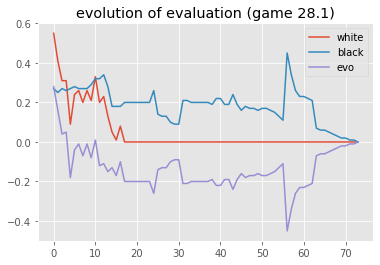

0.45


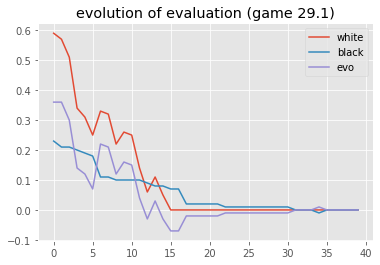

0.36


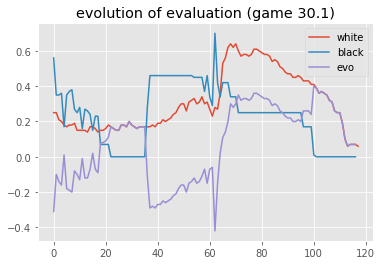

0.41999999999999993


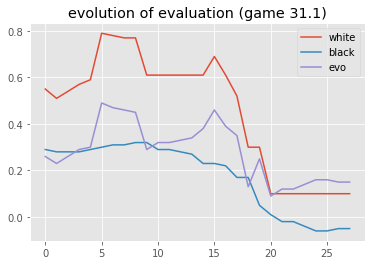

0.49000000000000005


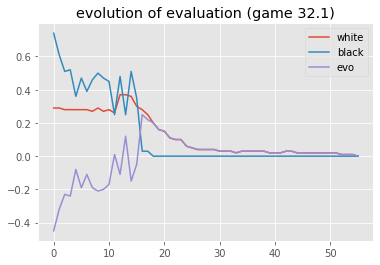

0.45


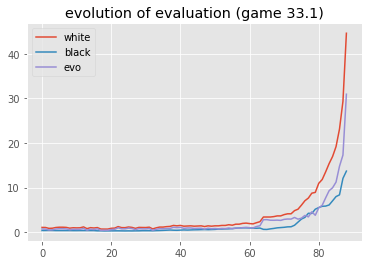

4.550000000000001


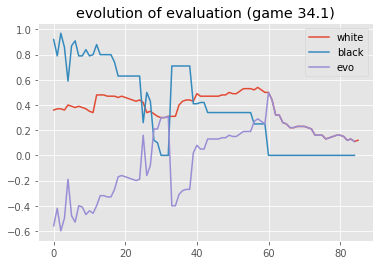

0.6


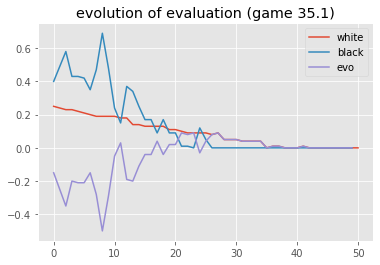

0.49999999999999994


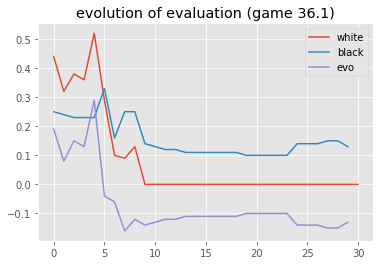

0.29000000000000004


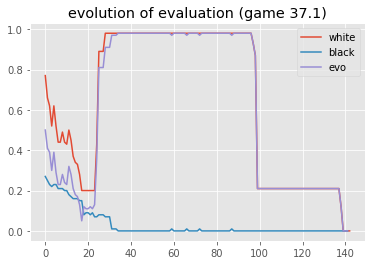

0.98


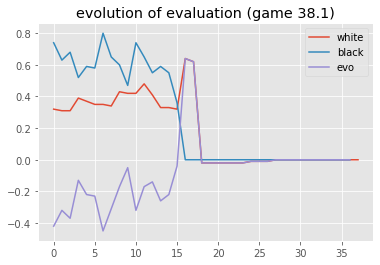

0.64


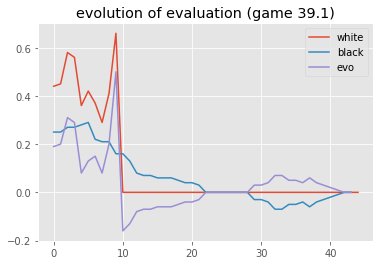

0.5


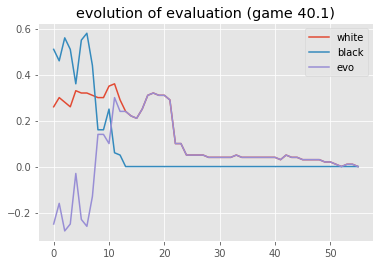

0.32


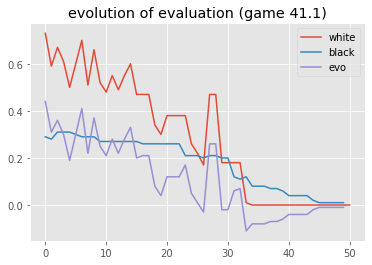

0.44


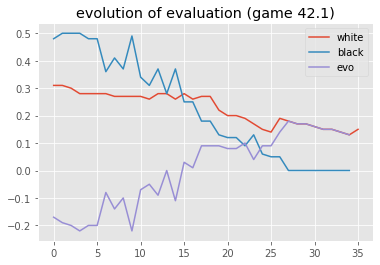

0.21999999999999997


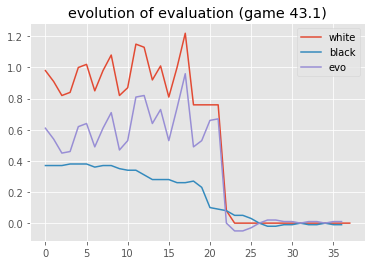

0.96


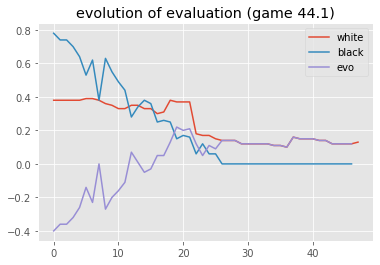

0.4


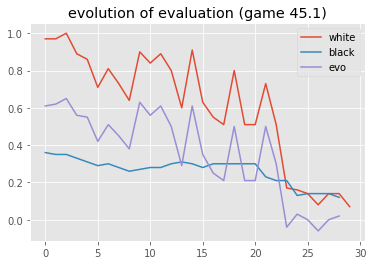

0.65


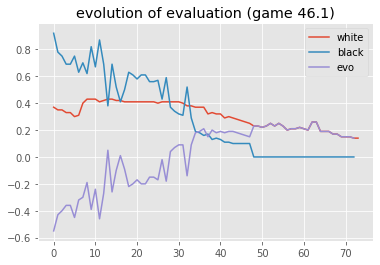

0.55


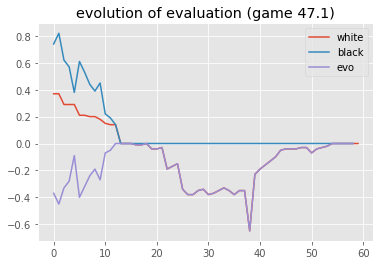

0.65


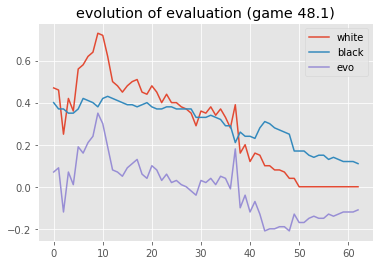

0.35


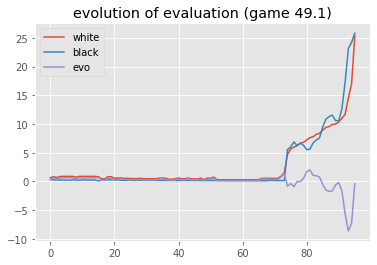

2.01


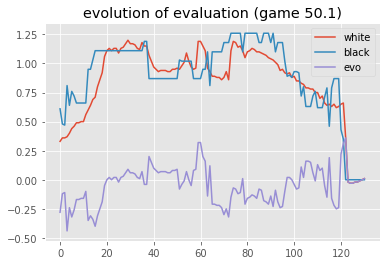

0.44000000000000006


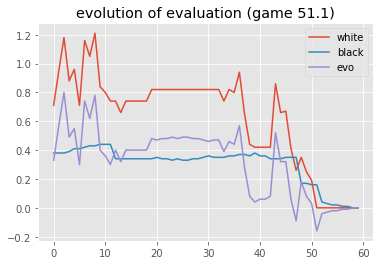

0.7999999999999999


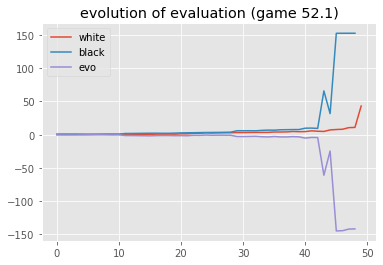

5.119999999999999


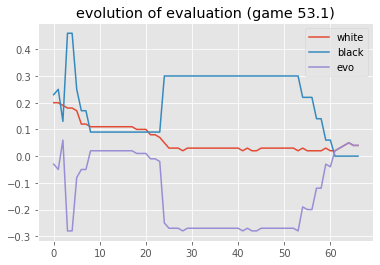

0.28


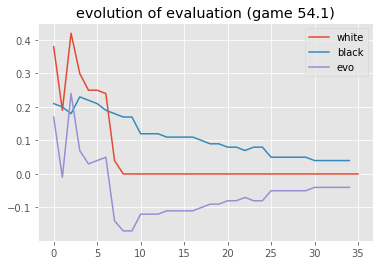

0.24


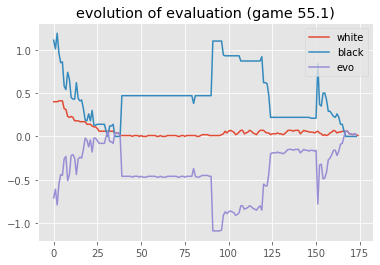

1.09


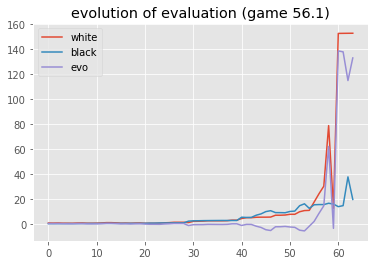

2.6099999999999994


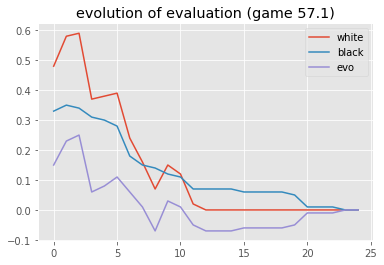

0.24999999999999994


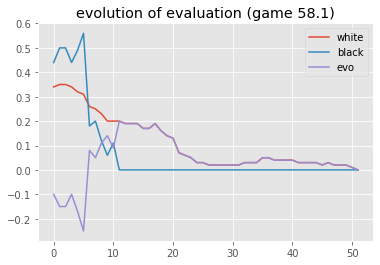

0.25000000000000006


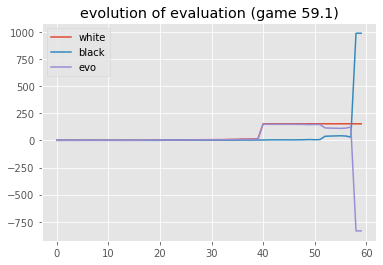

7.57


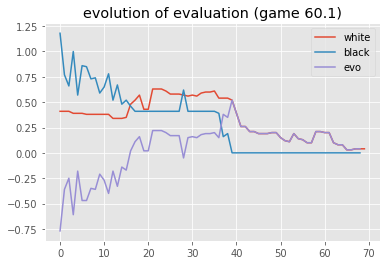

0.77


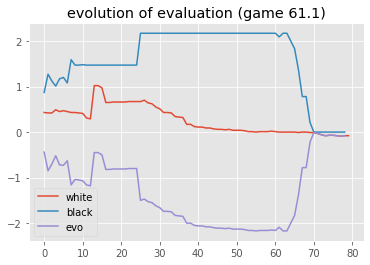

2.17


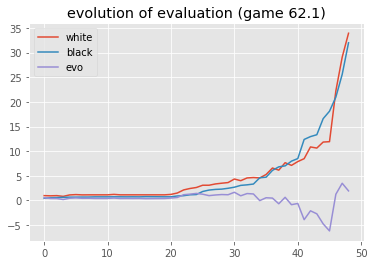

1.6599999999999997


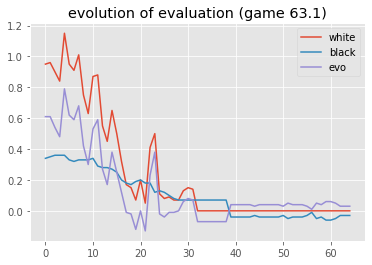

0.7899999999999999


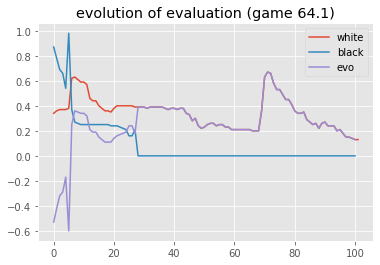

0.67


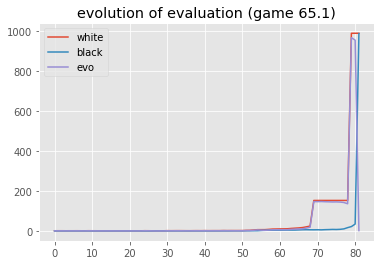

5.989999999999999


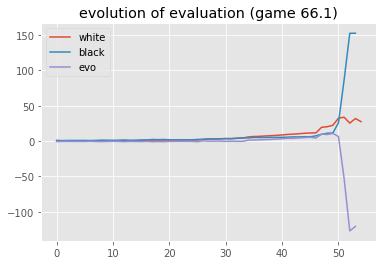

3.920000000000001


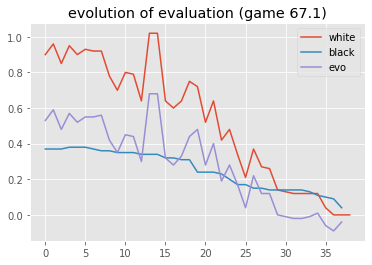

0.6799999999999999


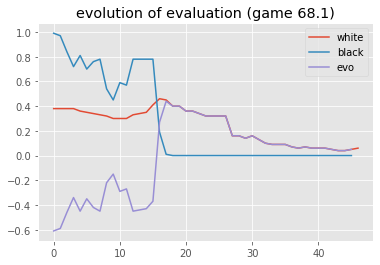

0.61


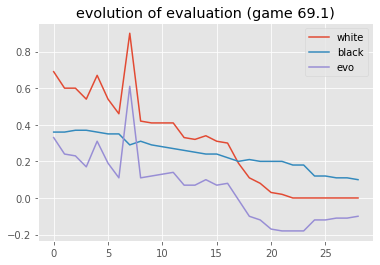

0.6100000000000001


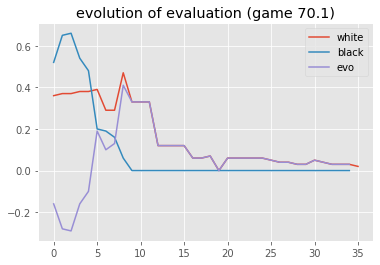

0.41


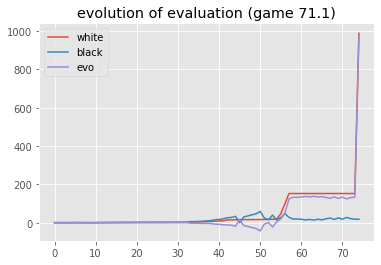

3.1599999999999993


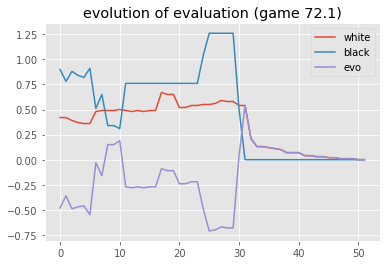

0.71


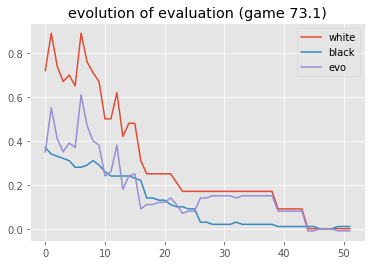

0.61


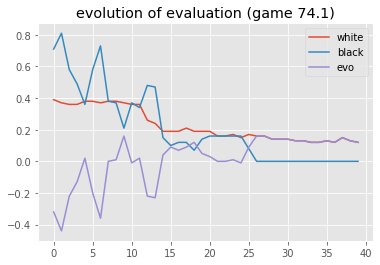

0.44000000000000006


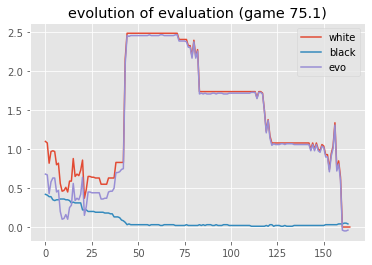

2.47


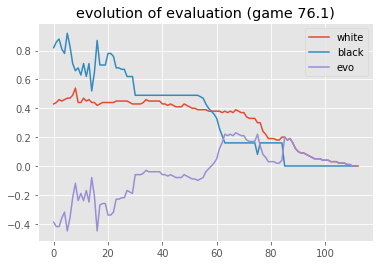

0.45000000000000007


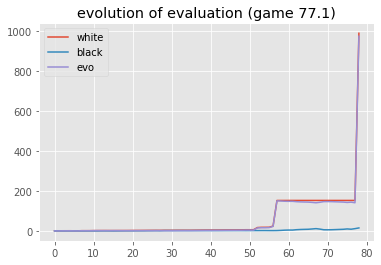

4.33


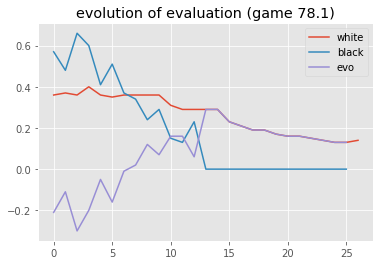

0.30000000000000004


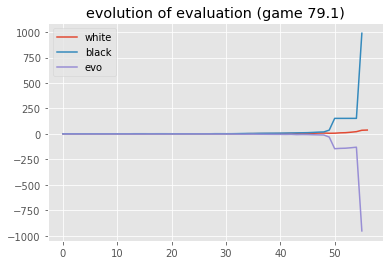

5.1


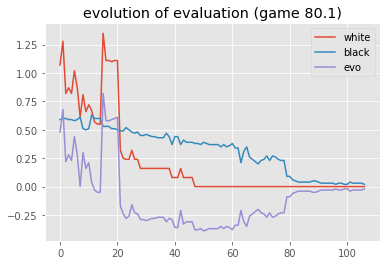

0.8200000000000001


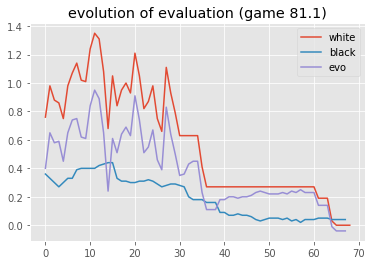

0.9500000000000001


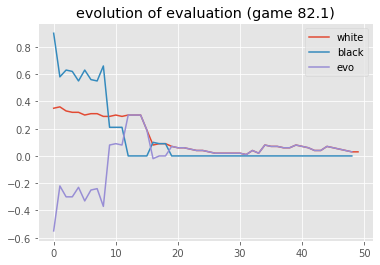

0.55


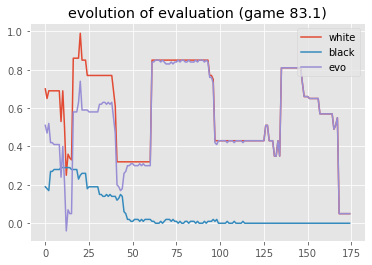

0.85


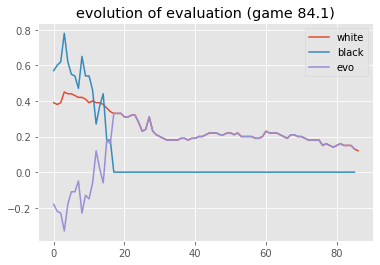

0.33


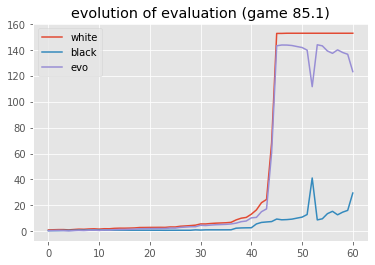

6.379999999999999


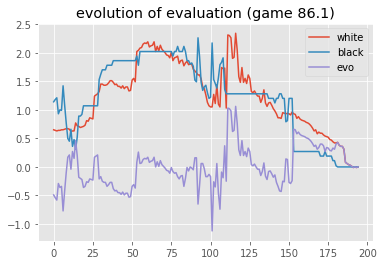

1.1199999999999999


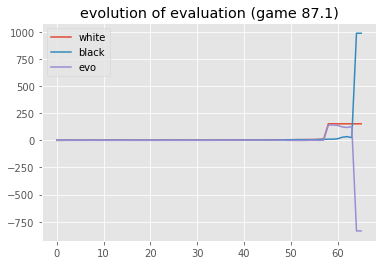

2.05


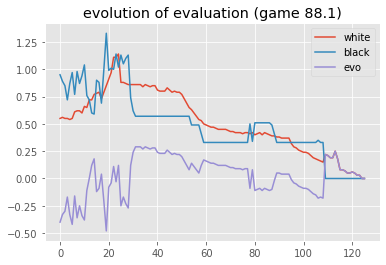

0.4800000000000001


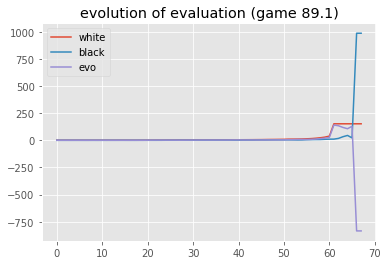

4.94


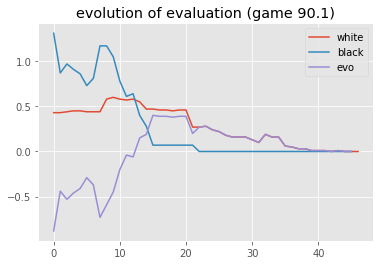

0.8800000000000001


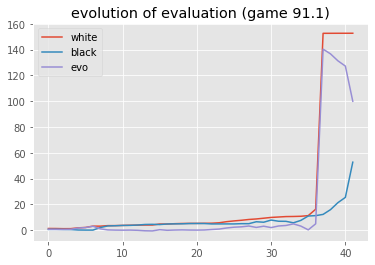

3.26


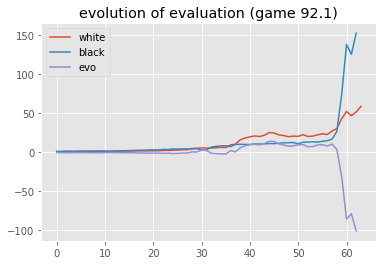

2.8399999999999994


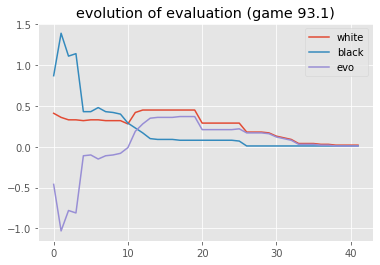

1.0299999999999998


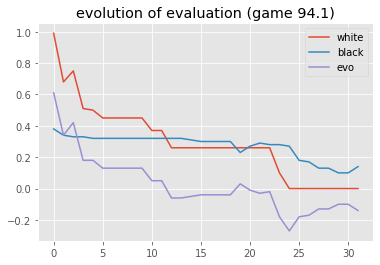

0.61


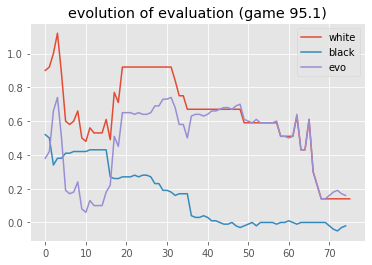

0.7400000000000001


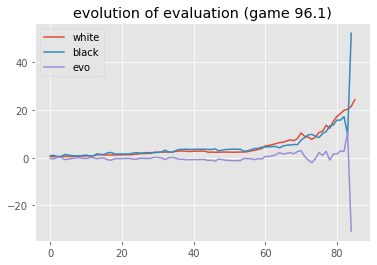

2.579999999999999


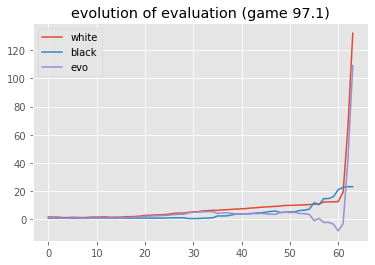

5.2700000000000005


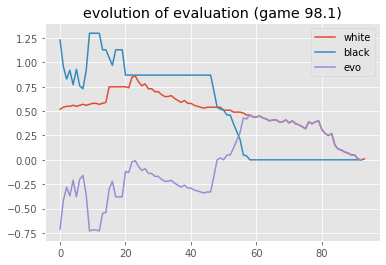

0.7300000000000001


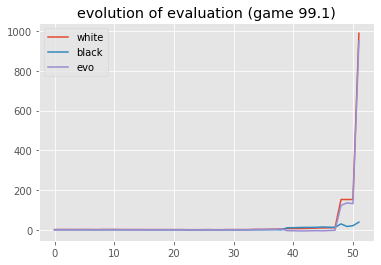

4.3


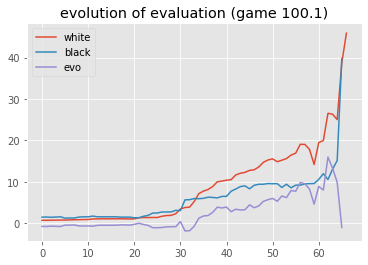

2.619999999999999


In [3]:
# http://talkchess.com/forum3/viewtopic.php?t=74375
'''
d      depth
sd     selective depth
pd     predicted move (ponder)
mt     move time
tl     time left
s      speed
n      nodes
pv     predicted variation
tb     tablebase hits
h      ?
ph     ponder hit ratio (in percentage)
wv     evaluation in pawns from white POV (white value)
R50    remaining moves before application of the 50-move-draw-rule
Rd     ?
Rr     ?
mb     material balance (P-p N-n B-b R-r Q-q)
'''


CHECK_MATE_VALUE=1000.0
def process_game(g):
    ground = g.headers.get("Round")
    w_wvs = []
    b_wvs = []
    white_turn=True
    completely_finished=False # M35 or M38 ... I guess mate is unavoidable 
    for node in g.mainline():
        if completely_finished:
            break
        metadata = node.comment
        if "book" in metadata:
            continue
        # print(metadata)
        # TODO: parse metadata (it's a string)
        for data in metadata.split(","):
            # key=value
            kv = data.split("=")
            if len(kv) > 1:
                k = kv[0].strip()
                v = kv[1].strip()
                # print(k, v)
                if (k == 'wv'):
                    try:
                        fv = float(v)
                    except ValueError:
                        # print("Mate?", v)
                        fv = CHECK_MATE_VALUE
                        completely_finished=True
                        break
                    if (white_turn):
                        w_wvs.append(fv)
                    else:
                        b_wvs.append(fv)
        white_turn= not white_turn

    plt.figure()
    plt.plot(w_wvs)
    plt.plot(b_wvs)
    plt.plot([x - y for x, y in zip(w_wvs, b_wvs)])
    plt.legend(["white", "black", "evo"])
    plt.title("evolution of evaluation (game " + ground + ")")
    # df.boxplot(column=['nbmoves'])
    plt.show()
    return w_wvs, b_wvs

# https://tcec-chess.com/#div=sf&game=61&season=20
# https://tcec-chess.com/#div=sf&game=59&season=20
# https://tcec-chess.com/#div=sf&game=49&season=20  

# https://twitter.com/gmmds/status/1356024271886278657
# https://tcec-chess.com/#div=sf&game=97&season=20

pgn = open(pgnfile)
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    w_wvs, b_wvs = process_game(game)
    evol = [abs(x - y) for x, y in zip(w_wvs, b_wvs) if x < 10 and y < 10]
    print(max(evol))